# Predicting Melbourne House Prices
## Phase 2: Statistical Modelling

#### Group Name:

#### Name(s) & ID(s) of Group Members:

#### 

## Table of Contents
- [Introduction](#intro)
- [Statistical Modelling](#sm)
- [Critique & Limitations](#cl)
- [Summary & Conclusions](#sc)

- JH [Test for smaller set of data with stronger linear relation](#Test)

## Introduction <a id='intro'></a>

### Phase 1 Summary

A brief yet complete and accurate summary of the work conducted for your Phase 1 report and how they relate to your Phase 2 report. 

**Important Phase 2 Note:** Please do NOT include your Phase 1 report or its contents with your Phase 2 submissions. You can, however, make some changes with your Phase 1 tasks if you need to, and then ONLY include these changes with your Phase 2 report with some explanation for these changes.

Does this note above indicate that we should save our database from phase 1 as a distinct, clean database, and use that one for this project? - Francis

### Report Overview

A complete and accurate overview of the contents of your Phase 2 report. Clarification: A Table of Contents is not a report overview.

### Overview of Methodology

A detailed, complete, and accurate overview of your statistical modelling methodology (which is multiple linear regression).

## Statistical Modelling <a id='sm'></a>

### Model Overview

Overview of full model, including the variables and terms you are using in your regression model.

#### Module Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("ggplot")

data = pd.read_csv('clean_diamond_df.csv')

In [2]:
data.describe()

,carat,depth,table,x,y,z,price
count,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000,53917.000000
mean,0.797687,61.749565,57.456939,5.731605,5.733428,3.539409,3930.910474
std,0.473777,1.432318,2.234069,1.119402,1.111272,0.691620,3987.215003
min,0.200000,43.000000,43.000000,3.730000,3.680000,1.070000,326.000000
25%,0.400000,61.000000,56.000000,4.710000,4.720000,2.910000,949.000000
50%,0.700000,61.800000,57.000000,5.700000,5.710000,3.530000,2401.000000
75%,1.040000,62.500000,59.000000,6.540000,6.540000,4.040000,5323.000000
max,5.010000,79.000000,95.000000,10.740000,10.540000,6.980000,18823.000000


In [3]:
data.describe(include='object')

,cut,color,clarity
count,53917,53917,53917
unique,5,7,8
top,Ideal,G,SI1
freq,21547,11284,13063


### Categorical Features

Let's have a look at the unique values of the categorical columns. In Pandas, string types are of data type "object", and usually these would be the categorical features.

In [4]:
categoricalColumns = data.columns[data.dtypes==object].tolist()

for col in categoricalColumns:
    print('Unique values for ' + col)
    print(data[col].unique())
    print('')

Unique values for cut
['Ideal' 'Premium' 'Good' 'Very Good' 'Fair']

Unique values for color
['E' 'I' 'J' 'H' 'F' 'G' 'D']

Unique values for clarity
['SI2' 'SI1' 'VS1' 'VS2' 'VVS2' 'VVS1' 'I1' 'IF']



We need to remove the whitespace for 'Very Good' in cut.

In [5]:
data.loc[data['cut'] == 'Very Good', 'cut'] = 'Very_Good'

In [6]:
data['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very_Good', 'Fair'], dtype=object)

In [7]:
data.dtypes

carat      float64
cut         object
color       object
clarity     object
depth      float64
table      float64
x          float64
y          float64
z          float64
price        int64
dtype: object

In [8]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


### Model Fitting

Details of assumptions check, model selection, plots of residuals, and technical analysis of regression results.

**NOTE:** The second half of [this](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb) regression case study ("Statistical Modeling and Performance Evaluation" Section) will be **very helpful** for this Model Fitting section.

### Full Model
We begin by fitting a multiple linear regression that predicts age using all of the avaliable features. We call this the full model. First let's take a quick peak at the clean data.

In [9]:
data.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,326
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,326
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,327
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,334
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,335


When constructing the regression formula, we can manually add all the independent features. On the other hand, if there are lots of independent variables, we can get smart and use some string function tricks as below.

In [10]:
formula_string_indep_vars = ' + '.join(data.drop(columns='price').columns)
formula_string = 'price ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  price ~ carat + cut + color + clarity + depth + table + x + y + z


The formula string above works just fine with the Statsmodels module. The problem, however, is that we cannot do automatic variable selection with this formula. What we need for this purpose is "one-hot-encoding" of categorical features. For more information on this encoding, please refer to this page.

In the code chunk below, we first use the get_dummies() function in Pandas for one-hot-encoding of categorical features and then we construct a new formula string with the encoded features.

In [11]:
# one-hot-encoding of categorical features
# for this to work correctly, variable data types (numeric or categorical)
# must be correctly specified within the Pandas dataframe
data_encoded = pd.get_dummies(data, drop_first=True)
data_encoded.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,326,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,326,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,327,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,334,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,335,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [12]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='price').columns)
formula_string_encoded = 'price ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good + color_E + color_F + color_G + color_H + color_I + color_J + clarity_IF + clarity_SI1 + clarity_SI2 + clarity_VS1 + clarity_VS2 + clarity_VVS1 + clarity_VVS2


**For fun, let's add two interaction terms to our full model. Let's add the interaction of the capital feature with hours_per_week and race_White respectively.**

In [13]:
formula_string_encoded = formula_string_encoded + ' + carat:x + color_I:carat'

**Also, let's add the square of the hours_per_week feature to illustrate how we can add higher order terms to our linear regression.**

In [14]:
# formula_string_encoded = formula_string_encoded + ' + np.power(hours_per_week, 2)'
# print('formula_string_encoded: ', formula_string_encoded)

Now that we have defined our statistical model formula as a Python string, we fit an OLS (ordinary least squares) model to our encoded data.

In [15]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 2.560e+04
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:21:32   Log-Likelihood:            -4.5463e+05
No. Observations:               53917   AIC:                         9.093e+05
Df Residuals:                   53891   BIC:                         9.096e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       559.8083    716.921      0.781

The full model has an adjusted R-squared value of 0.921, which means that 92% of the variance is explained by the model. By looking at the p-values, we observe that all of them are highly significant.

Let's define a new data frame for actual price vs. predicted price and the residuals for the full model. We will use this data frame when plotting predicted values and the regression residuals.

In [16]:
residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.sample(10, random_state=999)

,actual,predicted,residual
32064,781,1032.434896,-251.434896
16425,6563,6530.041121,32.958879
31316,759,388.193655,370.806345
17416,6982,6984.141392,-2.141392
33033,814,1245.137921,-431.137921
22546,10602,9967.381088,634.618912
45067,1646,2127.477330,-481.477330
17216,6887,7582.846117,-695.846117
34624,872,584.797118,287.202882
372,2808,3194.767452,-386.767452


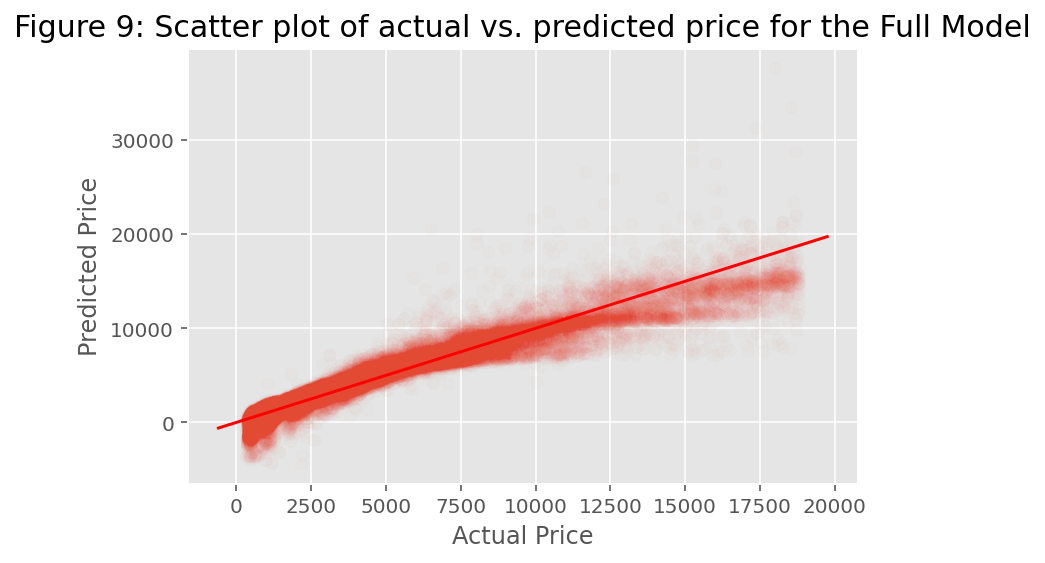

In [17]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.01);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Figure 9: Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

### Full Model Diagnostic Checks
We would like to check whether there are indications of violations of the regression assumptions, which are

1. linearity of the relationship between target variable and the independent variables
2. constant variance of the errors
3. normality of the residual distribution
4. statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted age).

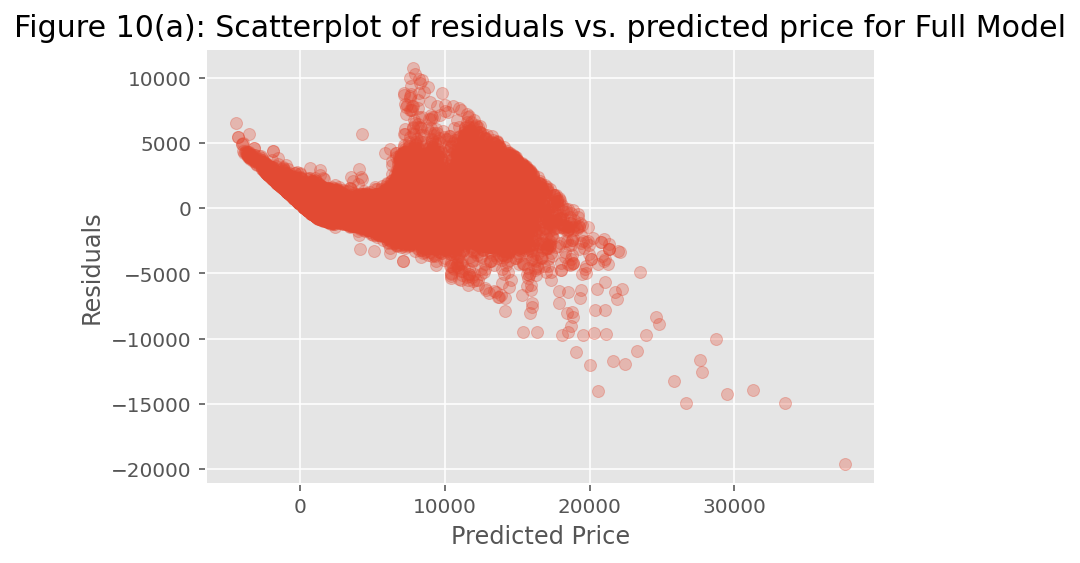

In [18]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted price for Full Model', fontsize=15)
plt.show();

The model seems to be under predicting on values above $15,000 by an extreme margin.

Let's now plot actual price vs. residuals.

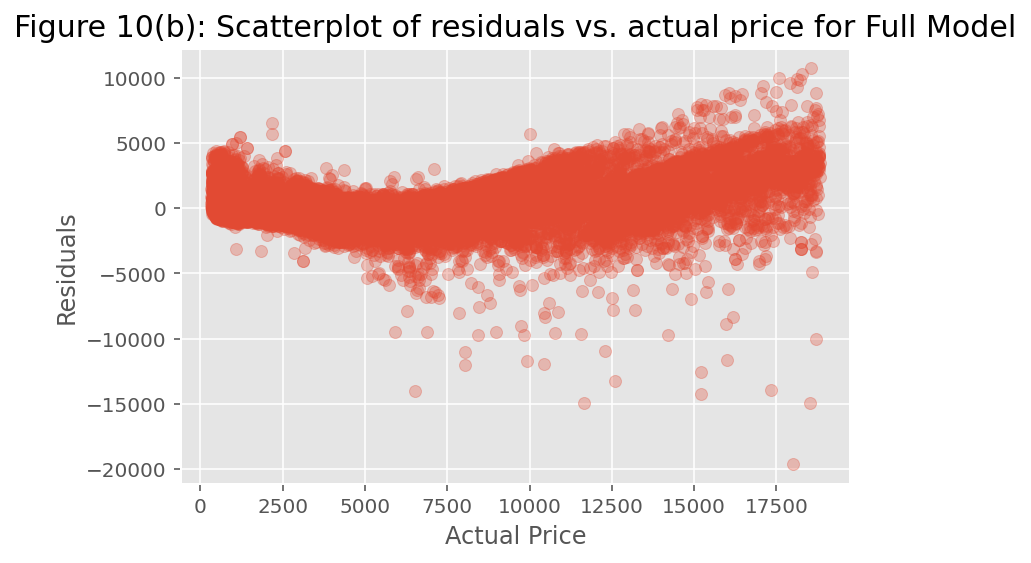

In [19]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

Let's overlay the histograms of actual vs. predicted age on the same plot.

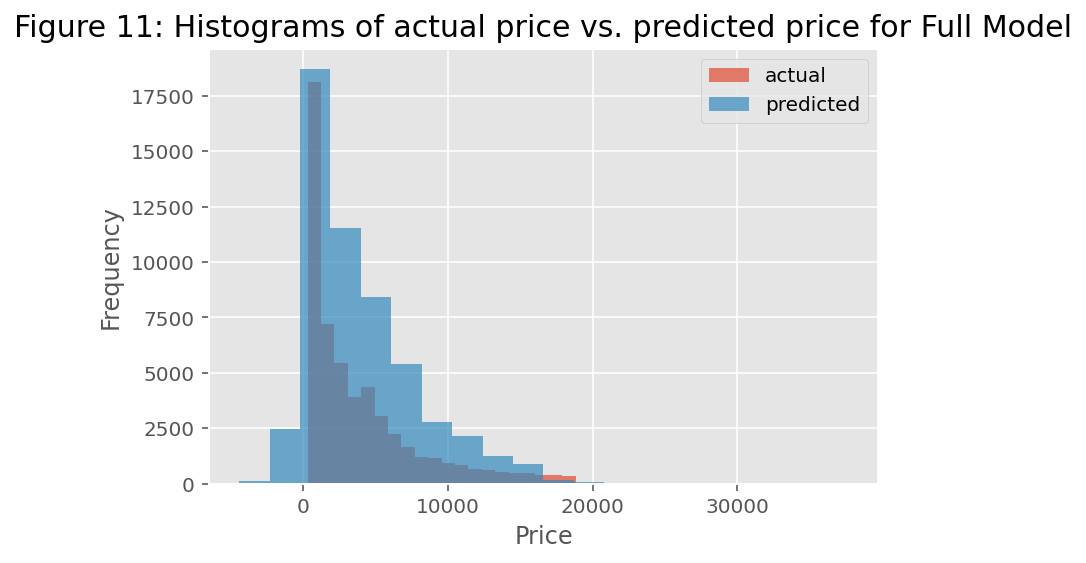

In [20]:
plt.hist(residuals_full['actual'], label='actual', bins=20, alpha=0.7);
plt.hist(residuals_full['predicted'], label='predicted', bins=20, alpha=0.7);
plt.xlabel('Price');
plt.ylabel('Frequency');
plt.title('Figure 11: Histograms of actual price vs. predicted price for Full Model', fontsize=15);
plt.legend()
plt.show();

Let's now have look at the histogram of the residuals.

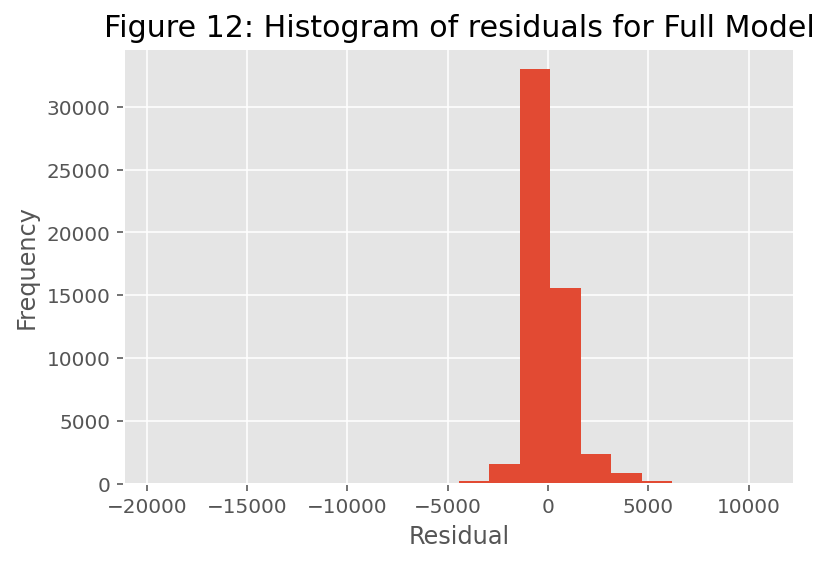

In [21]:
plt.hist(residuals_full['residual'], bins = 20);
plt.xlabel('Residual');
plt.ylabel('Frequency');
plt.title('Figure 12: Histogram of residuals for Full Model', fontsize=15);
plt.show();

In [22]:
residualsLog = np.log(residuals_full['residual'])

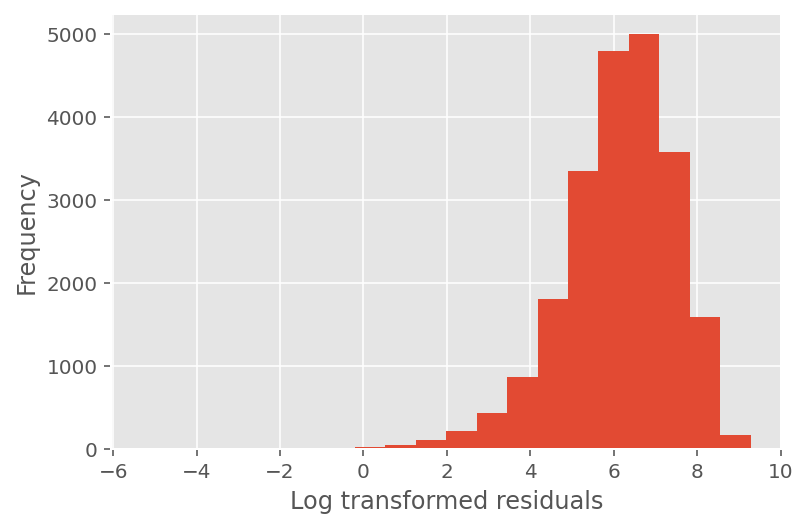

In [23]:
plt.hist(residualsLog, bins = 20);
plt.xlabel('Log transformed residuals');
plt.ylabel('Frequency');
plt.show();

#### Feature Selection

You can use the code below to to perform backward feature selection using p-values ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [24]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

***
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 2.560e+04
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:21:36   Log-Likelihood:            -4.5463e+05
No. Observations:               53917   AIC:                         9.093e+05
Df Residuals:                   53891   BIC:                         9.096e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

### Carat and Depth only test

In [25]:
formula_carat_string_encoded = 'price ~ carat + depth'

In [26]:
model_carat = sm.formula.ols(formula=formula_carat_string_encoded, data=data_encoded)
###
model_carat_fitted = model_carat.fit()
###
print(model_carat_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                 1.536e+05
Date:                Tue, 19 Oct 2021   Prob (F-statistic):               0.00
Time:                        13:21:36   Log-Likelihood:            -4.7226e+05
No. Observations:               53917   AIC:                         9.445e+05
Df Residuals:                   53914   BIC:                         9.445e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4065.4842    286.169     14.207      0.0

In [27]:
residuals_carat = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_carat_fitted.fittedvalues, 
                            'residual': model_carat_fitted.resid})
residuals_carat.sample(10, random_state=999)

,actual,predicted,residual
32064,781,243.066283,537.933717
16425,6563,5610.938496,952.061504
31316,759,956.475752,-197.475752
17416,6982,6025.576774,956.423226
33033,814,51.119760,762.880240
22546,10602,8265.516009,2336.483991
45067,1646,1686.041480,-40.041480
17216,6887,7204.866573,-317.866573
34624,872,221.002177,650.997823
372,2808,3266.947870,-458.947870


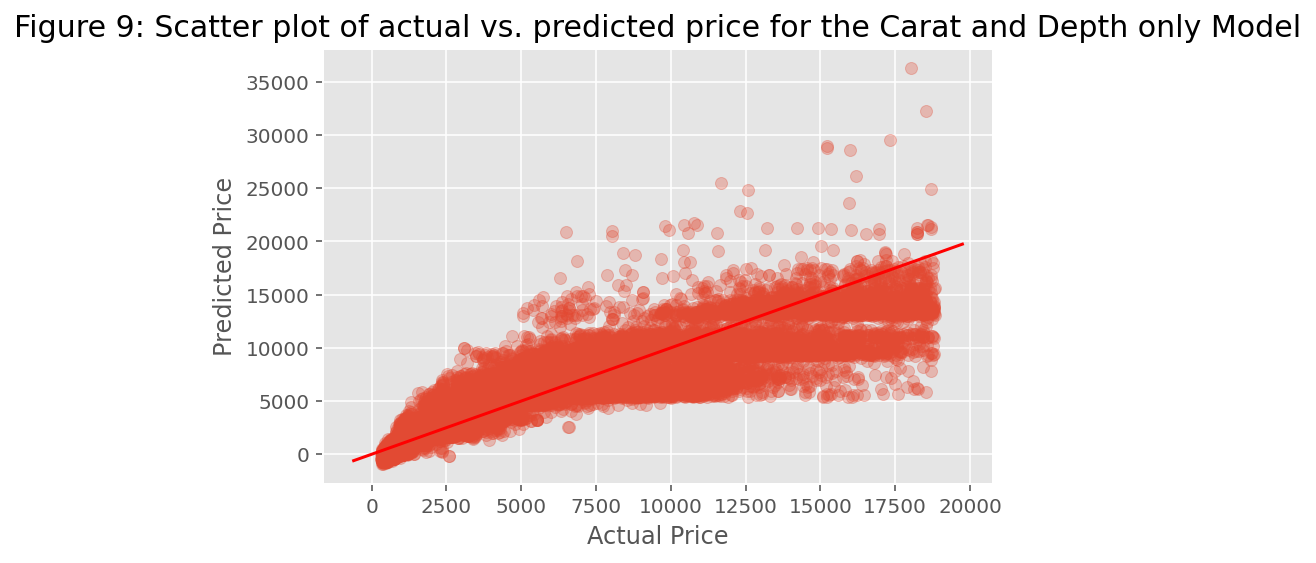

In [28]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_carat['actual'], residuals_carat['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Figure 9: Scatter plot of actual vs. predicted price for the Carat and Depth only Model', fontsize=15);
plt.show();

## Test for smaller set of data with stronger linear relation <a id='Test'></a>

Carat does not have a constant variability of residuals

In [29]:
colour_I_df = data[(data['color'] == 'I') & (data['clarity'] == 'I1') ]
colour_I_df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
653,1.01,Ideal,I,I1,61.5,57.0,6.45,6.46,3.97,2844
654,1.01,Good,I,I1,63.1,57.0,6.35,6.39,4.02,2844
857,1.04,Premium,I,I1,61.6,61.0,6.47,6.45,3.98,2870
865,1.02,Ideal,I,I1,61.7,56.0,6.44,6.49,3.99,2872
991,1.01,Very_Good,I,I1,63.1,57.0,6.39,6.35,4.02,2896


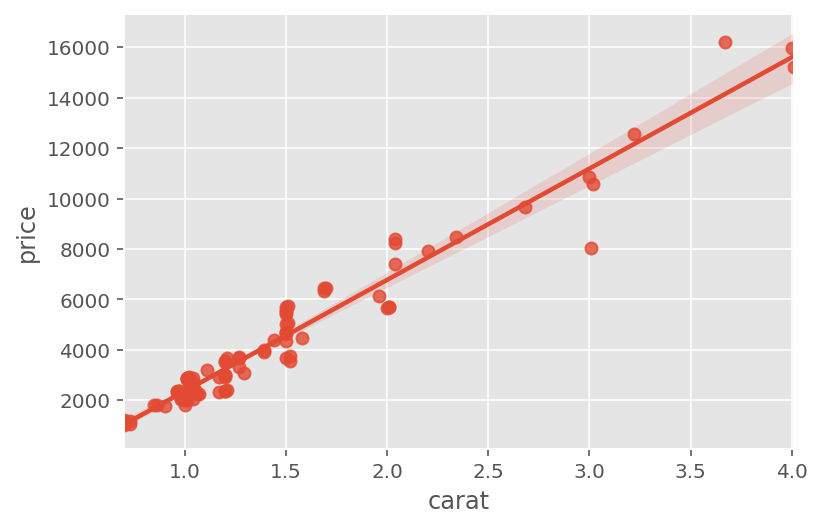

In [30]:
sns.regplot(x=colour_I_df['carat'], y=colour_I_df['price'])
plt.show()

With color set to I and clarity set to I1 there is a stronger linear relation. This is only a small data set of 92 rows, but useful as a check to confirm if our original full model results are incorrect.

In [31]:
colour_I_df = colour_I_df.drop(columns=['color', 'clarity'])
colour_I_df.head()

,carat,cut,depth,table,x,y,z,price
653,1.01,Ideal,61.5,57.0,6.45,6.46,3.97,2844
654,1.01,Good,63.1,57.0,6.35,6.39,4.02,2844
857,1.04,Premium,61.6,61.0,6.47,6.45,3.98,2870
865,1.02,Ideal,61.7,56.0,6.44,6.49,3.99,2872
991,1.01,Very_Good,63.1,57.0,6.39,6.35,4.02,2896


In [32]:
formula_string_indep_vars = ' + '.join(colour_I_df.drop(columns='price').columns)
formula_string = 'price ~ ' + formula_string_indep_vars
print('formula_string: ', formula_string)

formula_string:  price ~ carat + cut + depth + table + x + y + z


In [33]:
# one-hot-encoding of categorical features
# for this to work correctly, variable data types (numeric or categorical)
# must be correctly specified within the Pandas dataframe
data_encoded = pd.get_dummies(colour_I_df, drop_first=True)
data_encoded.head()

,carat,depth,table,x,y,z,price,cut_Good,cut_Ideal,cut_Premium,cut_Very_Good
653,1.01,61.5,57.0,6.45,6.46,3.97,2844,0,1,0,0
654,1.01,63.1,57.0,6.35,6.39,4.02,2844,1,0,0,0
857,1.04,61.6,61.0,6.47,6.45,3.98,2870,0,0,1,0
865,1.02,61.7,56.0,6.44,6.49,3.99,2872,0,1,0,0
991,1.01,63.1,57.0,6.39,6.35,4.02,2896,0,0,0,1


In [34]:
formula_string_indep_vars_encoded = ' + '.join(data_encoded.drop(columns='price').columns)
formula_string_encoded = 'price ~ ' + formula_string_indep_vars_encoded
print('formula_string_encoded: ', formula_string_encoded)

formula_string_encoded:  price ~ carat + depth + table + x + y + z + cut_Good + cut_Ideal + cut_Premium + cut_Very_Good


In [35]:
model_full = sm.formula.ols(formula=formula_string_encoded, data=data_encoded)
###
model_full_fitted = model_full.fit()
###
print(model_full_fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.964
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     214.2
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           6.80e-54
Time:                        13:21:37   Log-Likelihood:                -719.57
No. Observations:                  92   AIC:                             1461.
Df Residuals:                      81   BIC:                             1489.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept     -1.024e+04   1.13e+04     -0.905

Here we still have a very high Adj. R-squared of almost 96% however, this model seems to give more realistic P values based on the Phase 1 results. eg. table and depth have high P values which corresponds to a weak correlation to price we saw in the scatter plots.

In [36]:
residuals_full = pd.DataFrame({'actual': data_encoded['price'], 
                            'predicted': model_full_fitted.fittedvalues, 
                            'residual': model_full_fitted.resid})
residuals_full.sample(10, random_state=999)

,actual,predicted,residual
19174,7934,7384.370978,549.629022
52569,2540,2356.962541,183.037459
19632,8257,7402.125446,854.874554
1599,3011,2923.367212,87.632788
13656,5593,5102.414759,490.585241
4751,3686,3653.939744,32.060256
13921,5667,6644.278857,-977.278857
26520,16193,14068.407356,2124.592644
48853,2035,1787.033508,247.966492
53852,2745,2933.590616,-188.590616


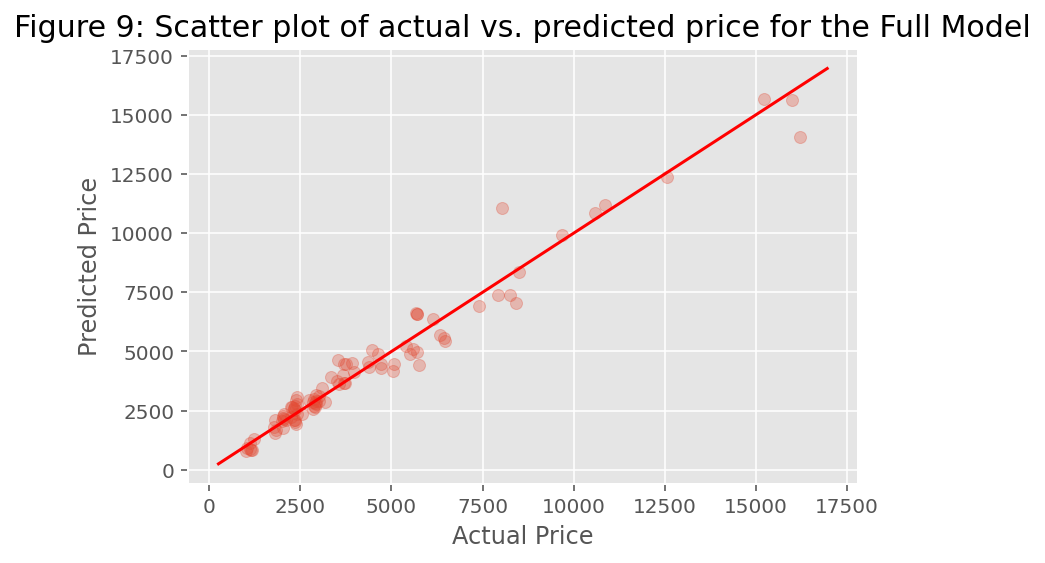

In [37]:
def plot_line(axis, slope, intercept, **kargs):
    xmin, xmax = axis.get_xlim()
    plt.plot([xmin, xmax], [xmin*slope+intercept, xmax*slope+intercept], **kargs)
    
# Creating scatter plot
plt.scatter(residuals_full['actual'], residuals_full['predicted'], alpha=0.3);
plot_line(axis=plt.gca(), slope=1, intercept=0, c="red");
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price');
plt.title('Figure 9: Scatter plot of actual vs. predicted price for the Full Model', fontsize=15);
plt.show();

### Full Model Diagnostic Checks
We would like to check whether there are indications of violations of the regression assumptions, which are

1. linearity of the relationship between target variable and the independent variables
2. constant variance of the errors
3. normality of the residual distribution
4. statistical independence of the residuals

Let's first get a scatter plot of residuals (as a function of predicted price).

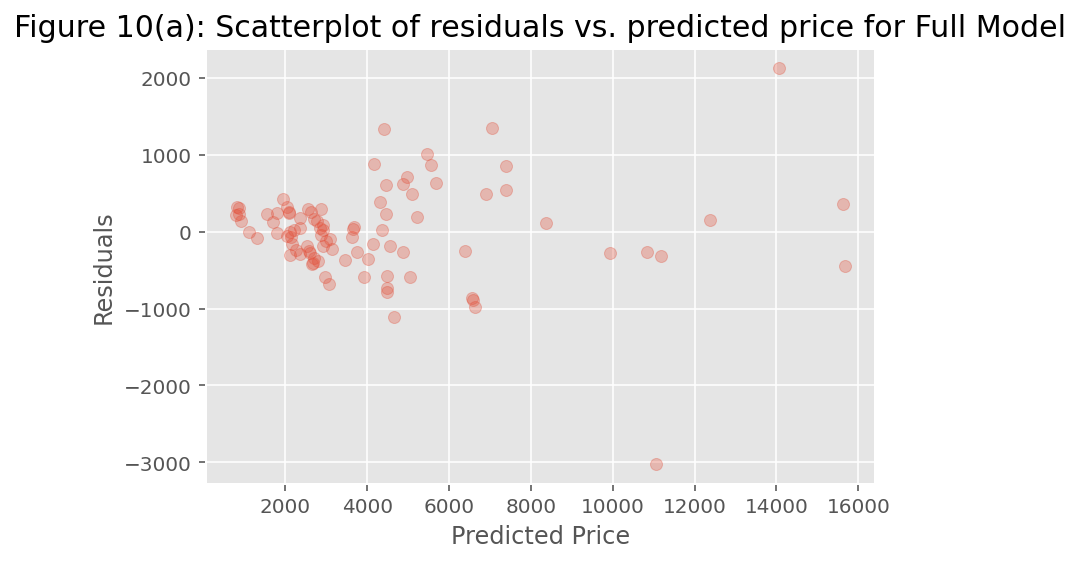

In [38]:
plt.scatter(residuals_full['predicted'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Predicted Price');
plt.ylabel('Residuals')
plt.title('Figure 10(a): Scatterplot of residuals vs. predicted price for Full Model', fontsize=15)
plt.show();

Outliers are of a concern here.

Let's now plot actual price vs. residuals.

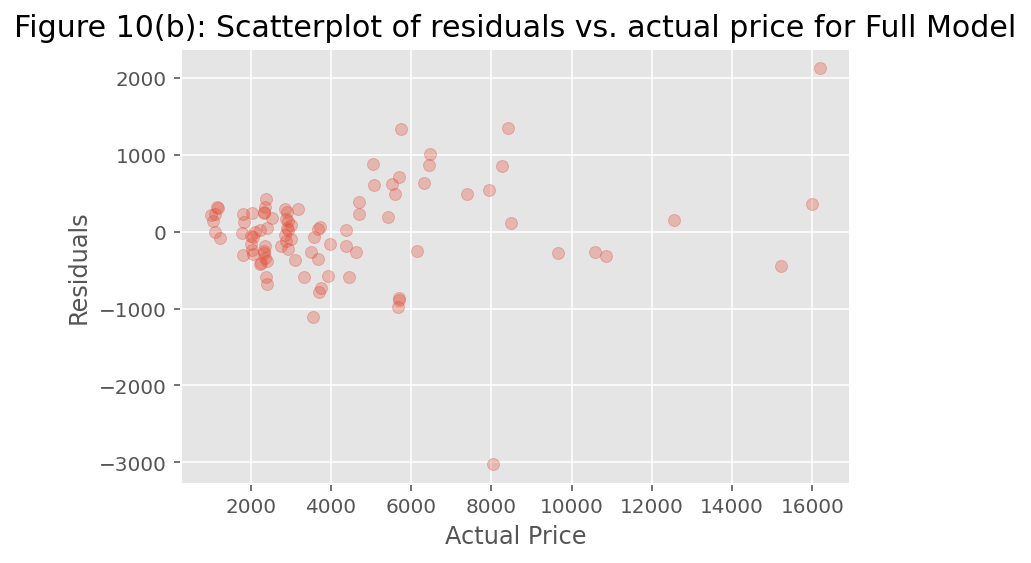

In [39]:
plt.scatter(residuals_full['actual'], residuals_full['residual'], alpha=0.3);
plt.xlabel('Actual Price');
plt.ylabel('Residuals')
plt.title('Figure 10(b): Scatterplot of residuals vs. actual price for Full Model', fontsize=15)
plt.show();

#### Feature Selection

You can use the code below to to perform backward feature selection using p-values ([credit](https://github.com/vaksakalli/stats_tutorials/blob/master/Regression_Case_Study1_web.ipynb)).

In [40]:
## create the patsy model description from formula
patsy_description = patsy.ModelDesc.from_formula(formula_string_encoded)

# initialize feature-selected fit to full model
linreg_fit = model_full_fitted

# do backwards elimination using p-values
p_val_cutoff = 0.05

## WARNING 1: The code below assumes that the Intercept term is present in the model.
## WARNING 2: It will work only with main effects and two-way interactions, if any.

print('\nPerforming backwards feature selection using p-values:')

while True:

    # uncomment the line below if you would like to see the regression summary
    # in each step:
    ### print(linreg_fit.summary())

    pval_series = linreg_fit.pvalues.drop(labels='Intercept')
    pval_series = pval_series.sort_values(ascending=False)
    term = pval_series.index[0]
    pval = pval_series[0]
    if (pval < p_val_cutoff):
        break
    term_components = term.split(':')
    print(f'\nRemoving term "{term}" with p-value {pval:.4}')
    if (len(term_components) == 1): ## this is a main effect term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0])]))    
    else: ## this is an interaction term
        patsy_description.rhs_termlist.remove(patsy.Term([patsy.EvalFactor(term_components[0]), 
                                                        patsy.EvalFactor(term_components[1])]))    
        
    linreg_fit = smf.ols(formula=patsy_description, data=data_encoded).fit()
    
###
## this is the clean fit after backwards elimination
model_reduced_fitted = smf.ols(formula = patsy_description, data = data_encoded).fit()
###
    
#########
print("\n***")
print(model_reduced_fitted.summary())
print("***")
print(f"Regression number of terms: {len(model_reduced_fitted.model.exog_names)}")
print(f"Regression F-distribution p-value: {model_reduced_fitted.f_pvalue:.4f}")
print(f"Regression R-squared: {model_reduced_fitted.rsquared:.4f}")
print(f"Regression Adjusted R-squared: {model_reduced_fitted.rsquared_adj:.4f}")


Performing backwards feature selection using p-values:

Removing term "z" with p-value 0.6478

Removing term "depth" with p-value 0.5285

Removing term "table" with p-value 0.6442

Removing term "cut_Good" with p-value 0.5428

Removing term "cut_Premium" with p-value 0.3025

Removing term "cut_Very_Good" with p-value 0.3558

Removing term "cut_Ideal" with p-value 0.09147

***
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.961
Model:                            OLS   Adj. R-squared:                  0.960
Method:                 Least Squares   F-statistic:                     721.3
Date:                Tue, 19 Oct 2021   Prob (F-statistic):           8.20e-62
Time:                        13:21:39   Log-Likelihood:                -722.78
No. Observations:                  92   AIC:                             1454.
Df Residuals:                      88   BIC:                       

Results of backward feature selection seems to be more appropriate than the original full model that did not remove any due to all having an apparently nearly 0 P value.

## Critique & Limitations <a id='cl'></a>

Critique & Limitations of your approach: strengths and weaknesses in detail.

## Summary & Conclusions <a id='sc'></a>

### Project Summary

A comprehensive summary of your entire project (both Phase 1 and Phase 2). That is, what exactly did you do in your project? (Example: I first cleaned the data in such and such ways. And then I applied multiple linear regression techniques in such and such ways. etc).

### Summary of Findings

A comprehensive summary of your findings. That is, what exactly did you find about your particular problem?

### Conclusions

Your detailed conclusions as they relate to your goals and objectives.